In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import torch
from torch.nn.utils import clip_grad_norm_
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [92]:
experiment = 'synth1'
abduction  = True

In [93]:
# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

In [94]:
Dll      = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')

Dhl      = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')

omega    = mut.load_omega_map(experiment)

In [95]:
ll_coeffs = mut.get_coefficients(Dll, Gll)
hl_coeffs = mut.get_coefficients(Dhl, Ghl) 

In [96]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [97]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [98]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [99]:
HLmodels[None].compute_mechanism()

array([[1.        , 0.60019745],
       [0.        , 1.        ]])

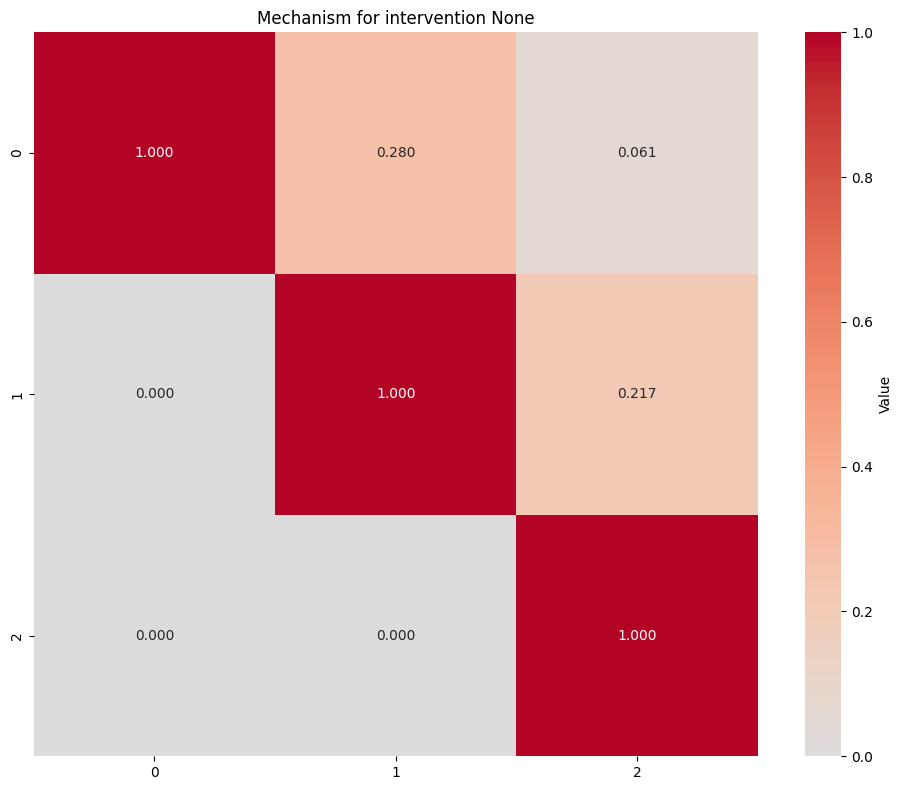

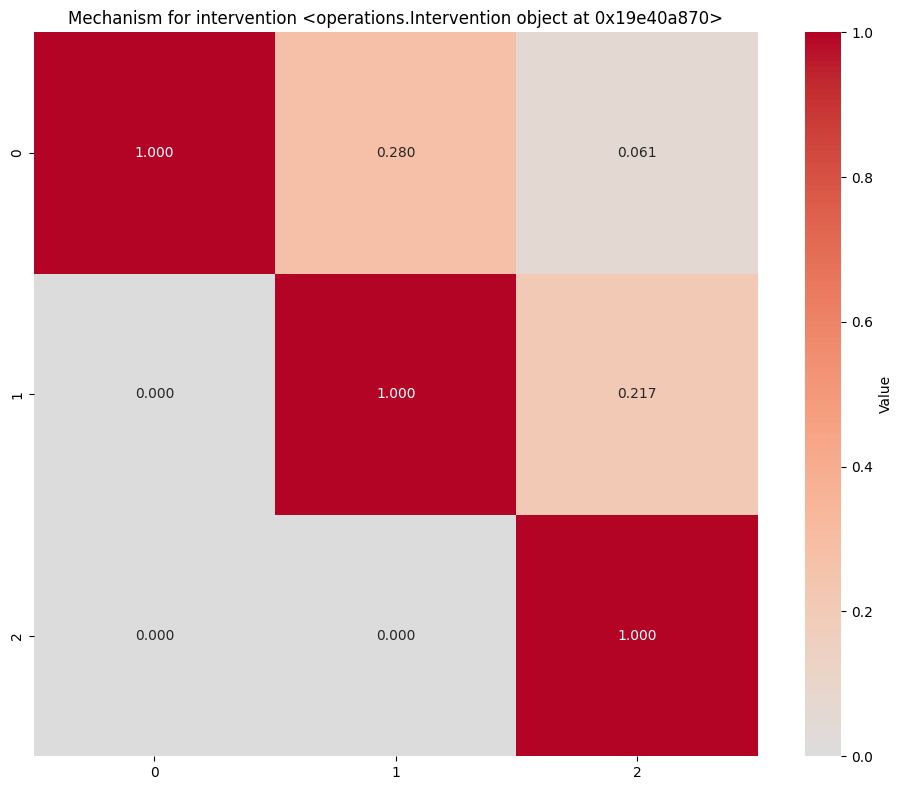

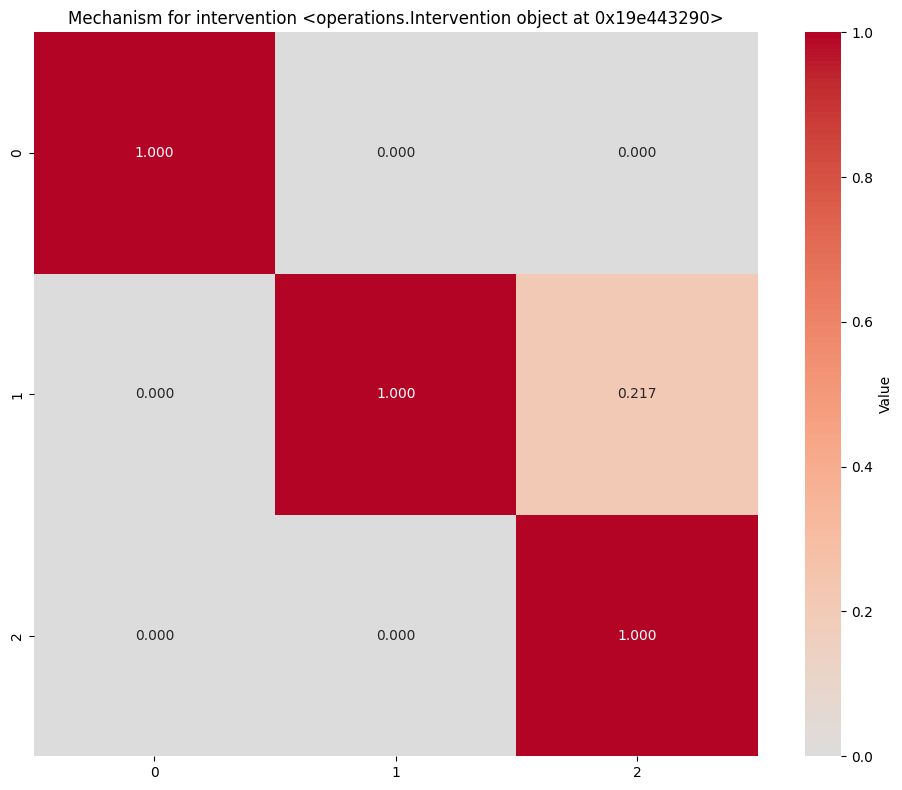

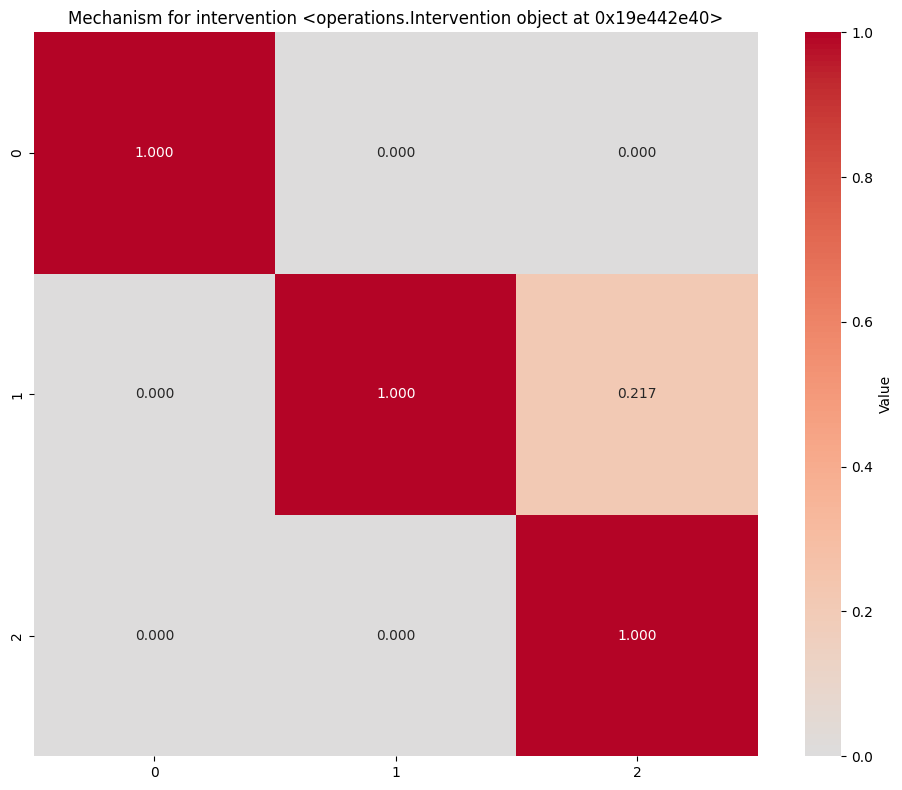

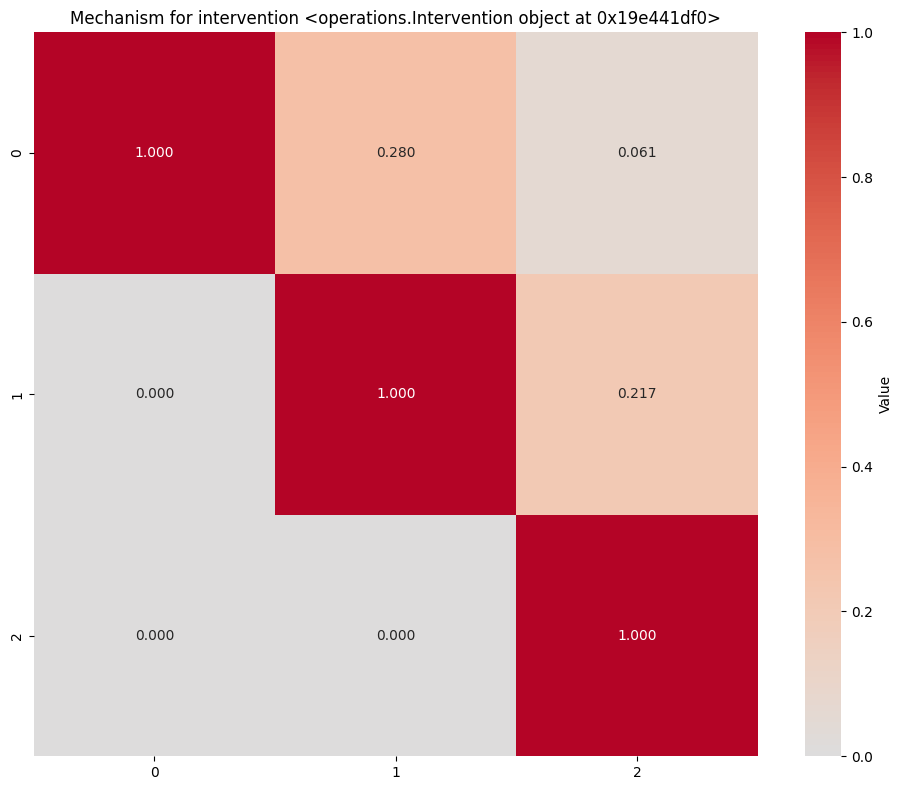

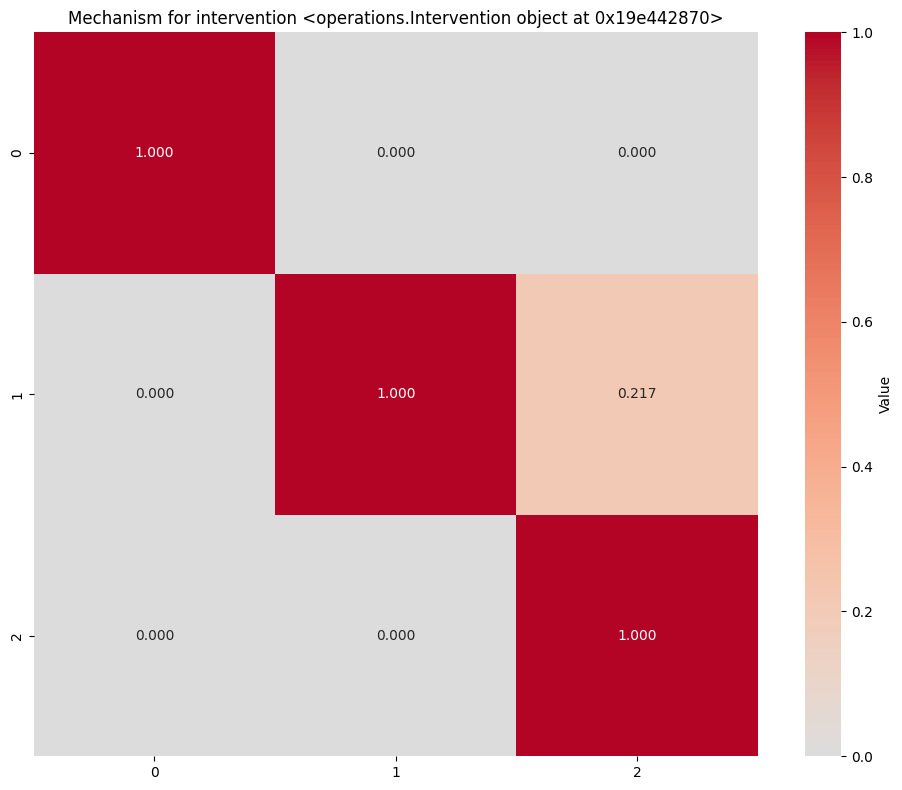

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mechanism_heatmap(matrix, title=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, 
                annot=True,           # Show numbers
                fmt='.3f',            # Format to 3 decimal places
                cmap='coolwarm',      # Color scheme
                center=0,             # Center the colormap at 0
                square=True,          # Make cells square
                cbar_kws={'label': 'Value'})  # Colorbar label
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot heatmap for each mechanism
for iota in Ill:
    mechanism = LLmodels[iota].compute_mechanism()
    plot_mechanism_heatmap(mechanism, f'Mechanism for intervention {iota}')

In [28]:
# # Ambiguity set construction: Based on epsilon and delta include distribution (as many as the num_envs) that
# # pass the "gelbrich" test.
# ll_moments = mut.sample_moments_U(mu_hat    = mu_U_ll_hat,
#                                   Sigma_hat = Sigma_U_ll_hat,
#                                   bound     = epsilon,
#                                   num_envs  = ll_num_envs)

# A_ll       = mut.sample_distros_Gelbrich(ll_moments) #Low-level: A_epsilon


# hl_moments = mut.sample_moments_U(mu_hat    = mu_U_hl_hat,
#                                   Sigma_hat = Sigma_U_hl_hat,
#                                   bound     = delta,
#                                   num_envs  = hl_num_envs)

# A_hl       = mut.sample_distros_Gelbrich(hl_moments) #High-level A_delta

In [29]:
for iota in Ill:
    L_i = LLmodels[iota].compute_mechanism()
    H_i = HLmodels[omega[iota]].compute_mechanism()

In [30]:
# abstraction_errors             = {}
# abstraction_env_errors         = {}
# max_env_avg_interv_error_value = -np.inf
# max_env_avg_interv_error_key   = None
# distance_err                   = 'wass'

# for lenv in A_ll:

#     Dll_noise      = lenv.sample(num_llsamples)[0]
#     ll_environment = mut.get_exogenous_distribution(Dll_noise)

#     for henv in A_hl:
#         Dhl_noise      = henv.sample(num_hlsamples)[0]
#         hl_environment = mut.get_exogenous_distribution(Dhl_noise)

#         total_ui_error = 0
#         num_distros    = len(Ill)

#         n, m  = len(LLmodels[None].endogenous_vars), len(HLmodels[None].endogenous_vars)

#         T     = mut.sample_stoch_matrix(n, m)

#         for iota in Ill:
#             llcm   = LLmodels[iota]
#             hlcm   = HLmodels[omega[iota]]
#             llmech = llcm.compute_mechanism()
#             hlmech = hlcm.compute_mechanism()
#             error  = mut.ui_error_dist(distance_err, lenv, henv, llmech, hlmech, T)

#             total_ui_error += error

#         avg_interv_error = total_ui_error/num_distros

#         if avg_interv_error > max_env_avg_interv_error_value:
#             max_env_avg_interv_error_value = avg_interv_error
#             max_env_avg_interv_error_key   = (lenv, henv)

#         abstraction_errors[str(T)] = avg_interv_error
#         abstraction_env_errors['ll: '+str(ll_environment.means_)+' hl: '+str(hl_environment.means_)] = avg_interv_error


# max_tau   = max(abstraction_errors, key=abstraction_errors.get)
# max_error = abstraction_errors[max_tau]

# print(f"Abstraction: {max_tau}, Error: {max_error}")
# print('==============================================================================' )
# max_lenv = max_env_avg_interv_error_key[0]
# max_henv = max_env_avg_interv_error_key[1]

# print(f"max LL mean vector = {max_lenv.means_}")
# print(f"max LL covariance = {max_lenv.covariances_}")
# print( )

# print(f"max HL mean vector = {max_henv.means_}")
# print(f"max HL covariance = {max_henv.covariances_}")
# print('==============================================================================' )
# print(f"max environment, average interventional abstraction error = {max_env_avg_interv_error_value}")

In [31]:
def update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta):
    grad_mu_L = torch.zeros_like(mu_L, dtype=torch.float32) 
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float() 
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float() 

        grad_mu_L += torch.matmul(V_i.T, torch.matmul(V_i, mu_L.float()) - torch.matmul(H_i, mu_H.float())) 
    
    grad_mu_L = (2 / n) * grad_mu_L - 2 * lambda_L * (mu_L - hat_mu_L)
    mu_L = mu_L + (eta * grad_mu_L)
    return mu_L

def update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta):
    grad_mu_H = torch.zeros_like(mu_H, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()  

        grad_mu_H -= torch.matmul(H_i.T, torch.matmul(V_i, mu_L.float()) - torch.matmul(H_i, mu_H.float()))
    
    grad_mu_H = (2 / n) * grad_mu_H - 2 * lambda_H * (mu_H - hat_mu_H)
    
    mu_H = mu_H + (eta * grad_mu_H)
    return mu_H


def update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta):
    grad_Sigma_L = torch.zeros_like(Sigma_L)
    term1 = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
        V_i = T @ L_i.float()
        term1 = term1 + torch.matmul(V_i.T, V_i)

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2 = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)

    grad_Sigma_L = (2 / n) * term1 + term2

    Sigma_L_half = Sigma_L + eta * grad_Sigma_L
    #Sigma_L_half  = diagonalize(Sigma_L_half)
    return Sigma_L_half


def update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):
    Sigma_L_final = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = torch.matmul(V_i, torch.matmul(Sigma_L_half, V_i.T))
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V))
        prox_Sigma_L_half = torch.matmul(oput.prox_operator(sqrtm_V_Sigma_V, lambda_param), oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T)
        
        # V_i = oput.regmat(V_i)

        # print('V_i', V_i)
        # print('T', T)
        # print('L_i', L_i)
        # print( )
        # print('torch.linalg.pinv(V_i)', torch.linalg.pinv(V_i))
        # print('oput.regmat(torch.linalg.pinv(V_i))', oput.regmat(torch.linalg.pinv(V_i)))
        ll_term_a = torch.matmul(oput.regmat(torch.linalg.pinv(V_i)), oput.regmat(prox_Sigma_L_half))
        ll_term_b = torch.linalg.pinv(V_i).T
        ll_term   = torch.matmul(ll_term_a, ll_term_b)
        #ll_term           = torch.matmul(torch.matmul(torch.linalg.pinv(V_i), oput.regmat(prox_Sigma_L_half)), torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = torch.matmul(H_i, torch.matmul(Sigma_H, H_i.T)).float()
        hl_term   = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro')

        Sigma_L_final = Sigma_L_final + (ll_term * hl_term)

    Sigma_L_final = Sigma_L_final * (2 / n)
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final


def update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta):
    grad_Sigma_H = torch.zeros_like(Sigma_H)
    term1        = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i   = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()
        term1 = term1 + torch.matmul(H_i.T, H_i)

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2 = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)

    grad_Sigma_H = (2 / n) * term1 + term2

    Sigma_H_half = Sigma_H + eta * grad_Sigma_H
    return Sigma_H_half

def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix


def update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param):
    if check_for_invalid_values(Sigma_L):
        print("Sigma_L contains NaN or Inf values!")
    Sigma_H_final = torch.zeros_like(Sigma_H_half)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
        V_i = T @ L_i.float()
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()

        H_Sigma_H         = torch.matmul(H_i, torch.matmul(Sigma_H_half, H_i.T))
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(oput.regmat(H_Sigma_H))
        prox_Sigma_H_half = torch.matmul(oput.prox_operator(sqrtm_H_Sigma_H, lambda_param), oput.prox_operator(sqrtm_H_Sigma_H, lambda_param).T)
        hl_term           = torch.matmul(torch.matmul(torch.inverse(H_i), oput.regmat(prox_Sigma_H_half)), torch.inverse(H_i).T)  
        
        V_Sigma_V = torch.matmul(V_i, torch.matmul(Sigma_L, V_i.T))
        ll_term   = torch.norm(oput.sqrtm_svd(oput.regmat(V_Sigma_V)))

        Sigma_H_final = Sigma_H_final + (ll_term * hl_term)
    
    Sigma_H_final = Sigma_H_final * (2 / n)
    Sigma_H_final = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [32]:
def check_constraints(mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, epsilon, delta):
    # Constraint 1: epsilon^2 - ||mu_L - hat_mu_L||_2^2 - ||Sigma_L^{1/2} - hat_Sigma_L^{1/2}||_2^2 >= 0
    constraint_L = epsilon**2 - (torch.norm(mu_L - hat_mu_L)**2) - (torch.norm(oput.sqrtm_svd(Sigma_L) - oput.sqrtm_svd(hat_Sigma_L))**2)
    
    # Constraint 2: delta^2 - ||mu_H - hat_mu_H||_2^2 - ||Sigma_H^{1/2} - hat_Sigma_H^{1/2}||_2^2 >= 0
    constraint_H = delta**2 - (torch.norm(mu_H - hat_mu_H)**2) - (torch.norm(oput.sqrtm_svd(Sigma_H) - oput.sqrtm_svd(hat_Sigma_H))**2)
    
    # Return whether constraints are satisfied (i.e., >= 0) and the constraint violations
    return constraint_L, constraint_H


def enforce_constraints(mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, epsilon, delta):
    constraint_L, constraint_H = check_constraints(mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, epsilon, delta)
    
    # Clip values if constraints are violated
    if constraint_L < 0:
        print(f"Constraint for mu_L and Sigma_L violated. Fixing...")
        mu_L = hat_mu_L + torch.clamp(mu_L - hat_mu_L, min=-epsilon, max=epsilon)
        Sigma_L = hat_Sigma_L + torch.clamp(Sigma_L - hat_Sigma_L, min=-epsilon, max=epsilon)
    
    if constraint_H < 0:
        print(f"Constraint for mu_H and Sigma_H violated. Fixing...")
        mu_H = hat_mu_H + torch.clamp(mu_H - hat_mu_H, min=-delta, max=delta)
        Sigma_H = hat_Sigma_H + torch.clamp(Sigma_H - hat_Sigma_H, min=-delta, max=delta)
    
    return mu_L, Sigma_L, mu_H, Sigma_H

In [77]:
def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, lambda_L, lambda_H, lambda_param, eta, num_steps_max, epsilon, delta, seed):
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    for t in range(num_steps_max): 
        mu_L         = update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta)
        mu_H         = update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta)
        Sigma_L_half = update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta)
        Sigma_L      = update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param)
        Sigma_H_half = update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta)
        Sigma_H      = update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param)
        
        # Project onto Gelbrich balls
        mu_L, Sigma_L = project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        if not satisfied_L:
            print(f"Warning: Constraints not satisfied for mu_L and Sigma_L! Distance: {dist_L} and epsilon = {epsi}")

        if not satisfied_H:
            print(f"Warning: Constraints not satisfied for mu_H and Sigma_H! Distance: {dist_H} and delta = {delt}")

        #mu_L, Sigma_L, mu_H, Sigma_H = enforce_constraints(mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, epsilon, delta)
        
        obj = 0
        
        for i, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
            V_i = T @ L_i.float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()
                        
            L_i_mu_L = V_i @ mu_L
            H_i_mu_H = H_i @ mu_H
            term1 = torch.norm(L_i_mu_L.float() - H_i_mu_H.float())**2
            
            V_Sigma_V = oput.regmat(V_i.float() @ Sigma_L.float() @ V_i.T.float())
            H_Sigma_H = oput.regmat(H_i.float() @ Sigma_H.float() @ H_i.T.float())

            term2 = torch.trace(V_Sigma_V)
            term3 = torch.trace(H_Sigma_H)
            
            sqrtVSV = oput.sqrtm_svd(V_Sigma_V)
            sqrtHSH = oput.sqrtm_svd(H_Sigma_H)

            term4 = -2 * torch.trace(oput.sqrtm_svd(oput.regmat(sqrtVSV @ sqrtHSH @ sqrtVSV)))
            #term4 = -2 * torch.norm(sqrtVSV @ sqrtHSH, 'nuc')
            
            obj = obj + (term1 + term2 + term3 + term4)
        
        obj = obj/i
        
        #print(f"Max step {t+1}/{num_steps_max}, Objective: {obj.item()}")

    return obj, mu_L, Sigma_L, mu_H, Sigma_H


def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, num_steps_min, optimizer_T, seed):
    print("Initial values:")
    print("T:", T)
    print("mu_L:", mu_L)
    print("Sigma_L:", Sigma_L)
    print("mu_H:", mu_H)
    print("Sigma_H:", Sigma_H)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    T = torch.nn.init.xavier_normal_(T, gain=0.01)
    #objective_T = 0
    objective_T = torch.tensor(0.0)  # Initialize as tensor instead of int 
    for step in range(num_steps_min):
        #objective_T = 0  # Reset objective at the start of each step
        objective_T = torch.tensor(0.0)
        for n, iota in enumerate(Ill):
            # Check for inf/nan values
            if torch.isinf(objective_T).any() or torch.isnan(objective_T).any():
                print(f"Invalid values detected in objective at step {step}")
                break

            L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()
            print(f"Step {step}, iteration {n}:")
            print("L_i:", L_i)
            print("H_i:", H_i)
            print("T @ L_i:", T @ L_i)
            L_i_mu_L = L_i @ mu_L  
            H_i_mu_H = H_i @ mu_H 

            term1 = torch.norm(T @ L_i_mu_L - H_i_mu_H) ** 2
            term2 = torch.trace(T @ L_i @ Sigma_L @ L_i.T @ T.T)
            term3 = torch.trace(H_i @ Sigma_H @ H_i.T)
            
            L_i_Sigma_L = oput.regmat(T @ L_i @ Sigma_L @ L_i.T @ T.T)
            H_i_Sigma_H = oput.regmat(H_i @ Sigma_H @ H_i.T)

            #term4 = -2 * torch.norm(oput.sqrtm_svd(L_i_Sigma_L) @ oput.sqrtm_svd(H_i_Sigma_H), 'nuc')
            term4 = -2 * torch.trace(oput.sqrtm_svd(oput.sqrtm_svd(L_i_Sigma_L) @ H_i_Sigma_H @ oput.sqrtm_svd(L_i_Sigma_L)))

            objective_T += term1 + term2 + term3 + term4

        objective_T = objective_T/n
        reg_lambda = 1e-4
        reg_term = reg_lambda * torch.norm(T, p=2)
        objective_T = objective_T + reg_term

        if step % 10 == 0:
            print(f"Step {step}, T values:")
            print(T)
            print("T grad:", T.grad)
            print("T grad norm:", T.grad.norm() if T.grad is not None else "None")

        optimizer_T.zero_grad() 
        objective_T.backward(retain_graph=True)  
        # Log the gradient norm
        grad_norm = T.grad.norm().item()
        #print(f"Step {step+1}/{num_steps_min}: Objective = {objective_T.item()}, Gradient Norm = {grad_norm}")

        #Check for NaN gradients
        if torch.isnan(T.grad).any():
            print(f"NaN gradients detected at step {step}")
            break

        optimizer_T.step()      

        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T.item()}")

    return objective_T, T 

In [78]:
def optimize_min_max(mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, 
                     hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
                     epsilon, delta, lambda_L, lambda_H, lambda_param, 
                     eta_min, eta_max, max_iter, num_steps_min, num_steps_max, tol, seed):
    
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    #T           = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    #optimizer_T = torch.optim.Adam([T], lr=0.001)
    #optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    optimizer_T = torch.optim.SGD([T], lr=1e-4, momentum=0.9)

    previous_objective       = float('inf')  
    for epoch in tqdm(range(max_iter)):
        #print(f"Epoch {epoch+1}/{max_iter}\n")
        #print("MINIMIZING T")
        print('current T = ', T)    
        # ---- Minimize T ----
        objective_T, T = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, num_steps_min, optimizer_T, seed)
        
        #print("MAX mu_L, Sigma_L, mu_H, Sigma_H")
        objective_theta, mu_L, Sigma_L, mu_H, Sigma_H = optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                         lambda_L, lambda_H, lambda_param, eta_max, num_steps_max, epsilon, delta, seed)
        if contains_negative(Sigma_L) == True:
            print('Sigma_L contains negative values')
            print(Sigma_L)
            print( )
        if contains_negative(Sigma_H) == True:
            print('Sigma_H contains negative values')
            print(Sigma_H)
            print( )

        criterion = abs(previous_objective - objective_T.item())
        
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break

        # Update previous objective for the next check
        previous_objective = objective_T.item()

    print("Final T:", T)
    print("Final mu_L:", mu_L)
    print("Final Sigma_L:", Sigma_L)
    print("Final mu_H:", mu_H)
    print("Final Sigma_H:", Sigma_H)

    return mu_L, Sigma_L, mu_H, Sigma_H, T


In [79]:
hat_mu_L    = torch.from_numpy(mu_U_ll_hat).float()
hat_Sigma_L = torch.from_numpy(Sigma_U_ll_hat).float()

hat_mu_H    = torch.from_numpy(mu_U_hl_hat).float()
hat_Sigma_H = torch.from_numpy(Sigma_U_hl_hat).float()

l = hat_mu_L.shape[0]
h = hat_mu_H.shape[0]

# Gelbrich initialization
ll_moments      = mut.sample_moments_U(mu_hat = mu_U_ll_hat, Sigma_hat = Sigma_U_ll_hat, bound = epsilon, num_envs = 1)
mu_L0, Sigma_L0 = ll_moments[0]
mu_L0, Sigma_L0 = torch.from_numpy(mu_L0).float(), torch.from_numpy(Sigma_L0).float()

hl_moments      = mut.sample_moments_U(mu_hat = mu_U_hl_hat, Sigma_hat = Sigma_U_hl_hat, bound = delta, num_envs = 1)
mu_H0, Sigma_H0 = hl_moments[0]
mu_H0, Sigma_H0 = torch.from_numpy(mu_H0).float(), torch.from_numpy(Sigma_H0).float()

In [80]:
def contains_negative(matrix):
    return (matrix < 0).any().item()

def project_onto_gelbrich_ball(mu, Sigma, hat_mu, hat_Sigma, epsilon, max_iter=100, tol=1e-6):
    """
    Project (mu, Sigma) onto the Gelbrich ball with detailed debugging
    """
    for i in range(max_iter):
        mu_dist_sq     = torch.sum((mu - hat_mu)**2)
        Sigma_sqrt     = oput.sqrtm_svd(Sigma)
        hat_Sigma_sqrt = oput.sqrtm_svd(hat_Sigma)
        Sigma_dist_sq  = torch.sum((Sigma_sqrt - hat_Sigma_sqrt)**2)
        
        G_squared      = mu_dist_sq + Sigma_dist_sq
        
        #print(f"Iteration {i}: G_squared = {G_squared.item()}, epsilon^2 = {epsilon**2}")
        
        if G_squared <= epsilon**2 + tol:
            #print(f"Projection converged in {i+1} iterations with G_squared = {G_squared.item()} and epsilon_sq = {epsilon**2}")
            break
        
        scale = epsilon / torch.sqrt(G_squared)

        mu         = hat_mu + scale * (mu - hat_mu)
        Sigma_diff = Sigma_sqrt - hat_Sigma_sqrt
        Sigma_sqrt = hat_Sigma_sqrt + scale * Sigma_diff
        Sigma      = torch.matmul(Sigma_sqrt, Sigma_sqrt.T)
        
       
    final_G_squared = torch.sum((mu - hat_mu)**2) + torch.sum((oput.sqrtm_svd(Sigma) - hat_Sigma_sqrt)**2)
    if final_G_squared > epsilon**2 + tol:
        print(f"Warning: Final G_squared = {final_G_squared.item()} > {epsilon**2}")
    
    return mu, Sigma

def verify_gelbrich_constraint(mu, Sigma, hat_mu, hat_Sigma, epsilon):
    """
    Verify constraint
    """
    mu_dist_sq = torch.sum((mu - hat_mu)**2)
    # print(f"mu distance squared: {mu_dist_sq.item()}")
    
    Sigma_sqrt = oput.sqrtm_svd(Sigma)
    hat_Sigma_sqrt = oput.sqrtm_svd(hat_Sigma)
    Sigma_dist_sq = torch.sum((Sigma_sqrt - hat_Sigma_sqrt)**2)
    # print(f"Sigma distance squared: {Sigma_dist_sq.item()}")
    
    G_squared = mu_dist_sq + Sigma_dist_sq
    # print(f"Total G_squared: {G_squared.item()}, epsilon^2: {epsilon**2}")

    G_squared       = round(G_squared.item(), 5)
    epsilon_squared = round(epsilon**2, 5)
    
    return G_squared <= epsilon_squared, G_squared, epsilon_squared

In [81]:
def update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):
    Sigma_L_final = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()  
        # print('L_i', L_i)
        # print('T', T)
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = torch.matmul(V_i, torch.matmul(Sigma_L_half, V_i.T))
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V))
        prox_Sigma_L_half = torch.matmul(oput.prox_operator(sqrtm_V_Sigma_V, lambda_param), oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T)
        
        V_i = oput.regmat(V_i)

        # print('V_i', V_i)
        # print('T', T)
        # print('L_i', L_i)
        # print( )
        # print('torch.linalg.pinv(V_i)', torch.linalg.pinv(V_i))
        # print('oput.regmat(torch.linalg.pinv(V_i))', oput.regmat(torch.linalg.pinv(V_i)))
        ll_term_a = torch.matmul(oput.regmat(torch.linalg.pinv(V_i)), oput.regmat(prox_Sigma_L_half))
        ll_term_b = torch.linalg.pinv(V_i).T
        ll_term   = torch.matmul(ll_term_a, ll_term_b)
        #ll_term           = torch.matmul(torch.matmul(torch.linalg.pinv(V_i), oput.regmat(prox_Sigma_L_half)), torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = torch.matmul(H_i, torch.matmul(Sigma_H, H_i.T)).float()
        hl_term   = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro')

        Sigma_L_final = Sigma_L_final + (ll_term * hl_term)

    Sigma_L_final = Sigma_L_final * (2 / n)
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

In [82]:
mu_L, Sigma_L, mu_H, Sigma_H, T = optimize_min_max(
                                                   mu_L0, Sigma_L0, mu_H0, Sigma_H0, LLmodels, HLmodels, 
                                                   hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
                                                   epsilon=0.2, delta=0.2, lambda_L=0.5, lambda_H=0.5, lambda_param=0.5, 
                                                   eta_max=0.001, eta_min=0.0001, max_iter=3,  num_steps_min=3, num_steps_max=2, tol=1e-4, seed=42
                                                  )

 33%|███▎      | 1/3 [00:00<00:00,  8.68it/s]

current T =  tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [ 0.3559, -0.6866, -0.4934,  0.2415, -1.1109,  0.0915, -2.3169, -0.2168],
        [-0.3097, -0.3957,  0.8034, -0.6216, -0.5920, -0.0631, -0.8286,  0.3309]],
       requires_grad=True)
Initial values:
T: tensor([[ 1.9269,  1.4873,  0.9007, -2.1055,  0.6784, -1.2345, -0.0431, -1.6047],
        [ 0.3559, -0.6866, -0.4934,  0.2415, -1.1109,  0.0915, -2.3169, -0.2168],
        [-0.3097, -0.3957,  0.8034, -0.6216, -0.5920, -0.0631, -0.8286,  0.3309]],
       requires_grad=True)
mu_L: tensor([ 0.0045,  0.1748,  0.1751, -0.0053,  0.2232,  0.1852,  0.0601, -0.1178])
Sigma_L: tensor([[0.9135, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.6914, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.1655, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 2.0957, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0

100%|██████████| 3/3 [00:00<00:00,  9.57it/s]


Step 0, iteration 2:
L_i: tensor([[1.0000, 0.1665, 0.0000, 0.0349, 0.0000, 0.0000, 0.0183, 0.0089],
        [0.0000, 1.0000, 0.0000, 0.2097, 0.0000, 0.0000, 0.1099, 0.0534],
        [0.0000, 0.1732, 1.0000, 0.0363, 0.0000, 0.0000, 0.0190, 0.0093],
        [0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.5242, 0.2549],
        [0.0000, 0.0000, 0.0000, 0.2252, 1.0000, 0.0000, 0.1180, 0.0574],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3594, 0.1105],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.3075],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]])
H_i: tensor([[1.0000, 0.6203, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 7.9777, 1.0000]])
T @ L_i: tensor([[ 0.0082,  0.0084,  0.0038, -0.0066,  0.0029, -0.0053, -0.0055, -0.0092],
        [ 0.0015, -0.0030, -0.0021, -0.0007, -0.0047,  0.0004, -0.0101, -0.0041],
        [-0.0013, -0.0013,  0.0034, -0.0035, -0.0025, -0.0003, -0.0055, -0.0006]],
       grad_fn=<M

### Run a grid-search

In [41]:
results_dir = f"{experiment}_erica_results"
os.makedirs(results_dir, exist_ok=True)

# Define parameter grids
param_grid = {
    'lambda_param': [0.2, 0.4, 0.6, 0.8, 1.0],
    # Add other hyperparameters here
}

# Fixed parameters
fixed_params = {
    'epsilon': 0.5,
    'delta': 0.5,
    'eta_max': 0.01,
    'eta_min': 0.001,
    'lambda_L': 0.8,
    'lambda_H': 0.8,
    'max_iter': 10,
    'num_steps_min': 1,
    'num_steps_max': 1,
    'tol_max': 1e-4,
    'tol': 1e-4,
    'seed': 42
}

# Generate all combinations of parameters
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Iterate over each combination
for idx, params in enumerate(param_combinations, 1):
    try:
        print(f"Running combination {idx}/{len(param_combinations)}: {params}")

        # Run your optimization function here
        final_mu_L, final_Sigma_L, final_mu_H, final_Sigma_H, final_T = optimize_min_max(
                                                                                        mu_L0, Sigma_L0, mu_H0, Sigma_H0,
                                                                                        LLmodels, HLmodels,
                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                        **params,
                                                                                        **fixed_params
                                                                                        )

        # Prepare results
        results = {
            'parameters': params,
            'mu_L': final_mu_L.detach().numpy(),
            'Sigma_L': final_Sigma_L.detach().numpy(),
            'mu_H': final_mu_H.detach().numpy(),
            'Sigma_H': final_Sigma_H.detach().numpy(),
            'T': final_T.detach().numpy(),
            'execution_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        # Save results
        result_filename = f"{results_dir}/result_{idx}.pkl"
        with open(result_filename, 'wb') as f:
            pickle.dump(results, f)

        print(f"Results saved to: {result_filename}")

    except Exception as e:
        print(f"Error with parameters {params}: {str(e)}")
        continue

Running combination 1/5: {'lambda_param': 0.2}


 30%|███       | 3/10 [00:00<00:00, 25.26it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 2.157719850540161, Gradient Norm = 3.592430353164673
Step 1/1: Objective = 2.0324082374572754, Gradient Norm = 2.9353740215301514
Step 1/1: Objective = 2.0185794830322266, Gradient Norm = 2.871495246887207
Step 1/1: Objective = 2.0127692222595215, Gradient Norm = 2.8650739192962646


 60%|██████    | 6/10 [00:00<00:00, 18.59it/s]

Step 1/1: Objective = 2.007770538330078, Gradient Norm = 2.8635976314544678
Step 1/1: Objective = 2.00293231010437, Gradient Norm = 2.862715482711792


 80%|████████  | 8/10 [00:00<00:00, 15.00it/s]

Step 1/1: Objective = 1.9981982707977295, Gradient Norm = 2.8620455265045166
Step 1/1: Objective = 1.9935672283172607, Gradient Norm = 2.8615567684173584


100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


Step 1/1: Objective = 1.9890460968017578, Gradient Norm = 2.861253261566162
Final T: tensor([[ 0.3467,  0.1189,  0.2439],
        [ 0.2403, -1.1140, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5633, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.5000, 0.0000],
        [0.0000, 1.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_1.pkl
Running combination 2/5: {'lambda_param': 0.4}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.7905457019805908, Gradient Norm = 3.2711431980133057


 40%|████      | 4/10 [00:00<00:00, 26.77it/s]

Step 1/1: Objective = 2.181090831756592, Gradient Norm = 3.886312246322632
Step 1/1: Objective = 1.9982795715332031, Gradient Norm = 2.9500863552093506
Step 1/1: Objective = 1.9930298328399658, Gradient Norm = 2.9484946727752686


 70%|███████   | 7/10 [00:00<00:00, 16.27it/s]

Step 1/1: Objective = 1.9878889322280884, Gradient Norm = 2.9471583366394043
Step 1/1: Objective = 1.9828557968139648, Gradient Norm = 2.946053981781006
Step 1/1: Objective = 1.9779307842254639, Gradient Norm = 2.9451639652252197


 90%|█████████ | 9/10 [00:00<00:00, 13.28it/s]

Step 1/1: Objective = 1.9731204509735107, Gradient Norm = 2.944492816925049


100%|██████████| 10/10 [00:00<00:00, 13.63it/s]


Step 1/1: Objective = 1.9684324264526367, Gradient Norm = 2.9440340995788574
Final T: tensor([[ 0.3466,  0.1188,  0.2443],
        [ 0.2402, -1.1142, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.5000, 0.0000],
        [0.0000, 1.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_2.pkl
Running combination 3/5: {'lambda_param': 0.6}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.5258506536483765, Gradient Norm = 3.138038396835327


 30%|███       | 3/10 [00:00<00:00, 29.34it/s]

Step 1/1: Objective = 1.5836281776428223, Gradient Norm = 3.502628803253174
Step 1/1: Objective = 1.6426475048065186, Gradient Norm = 3.956981897354126
Step 1/1: Objective = 1.697021722793579, Gradient Norm = 4.438928604125977
Step 1/1: Objective = 1.744328498840332, Gradient Norm = 4.839473247528076


 60%|██████    | 6/10 [00:00<00:00, 19.47it/s]

Step 1/1: Objective = 1.78388249874115, Gradient Norm = 5.183915138244629
Step 1/1: Objective = 1.8157119750976562, Gradient Norm = 5.470893859863281


 90%|█████████ | 9/10 [00:00<00:00, 13.90it/s]

Step 1/1: Objective = 1.8403030633926392, Gradient Norm = 5.699570655822754


100%|██████████| 10/10 [00:00<00:00, 13.54it/s]


Step 1/1: Objective = 1.858405351638794, Gradient Norm = 5.874941825866699
Final T: tensor([[ 0.3467,  0.1187,  0.2387],
        [ 0.2405, -1.1128, -0.1763]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1359, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.4179, 0.0000],
        [0.0000, 1.4033]], grad_fn=<DiagEmbedBackward0>)
Results saved to: synth1_erica_results/result_3.pkl
Running combination 4/5: {'lambda_param': 0.8}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206


 30%|███       | 3/10 [00:00<00:00, 29.63it/s]

Step 1/1: Objective = 1.3395202159881592, Gradient Norm = 3.0672192573547363
Step 1/1: Objective = 1.2413148880004883, Gradient Norm = 3.0120716094970703
Step 1/1: Objective = 1.2113540172576904, Gradient Norm = 2.903855323791504
Step 1/1: Objective = 1.202183723449707, Gradient Norm = 2.840022563934326


 60%|██████    | 6/10 [00:00<00:00, 19.13it/s]

Step 1/1: Objective = 1.197507619857788, Gradient Norm = 2.8274905681610107
Step 1/1: Objective = 1.1934016942977905, Gradient Norm = 2.820382833480835
Step 1/1: Objective = 1.1894582509994507, Gradient Norm = 2.813884973526001


 90%|█████████ | 9/10 [00:00<00:00, 13.80it/s]

Step 1/1: Objective = 1.1856379508972168, Gradient Norm = 2.807492971420288


100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Step 1/1: Objective = 1.1819442510604858, Gradient Norm = 2.801156520843506
Final T: tensor([[ 0.3458,  0.1190,  0.2441],
        [ 0.2401, -1.1129, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 0.8770]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_4.pkl
Running combination 5/5: {'lambda_param': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.2434988021850586, Gradient Norm = 2.9818167686462402


 30%|███       | 3/10 [00:00<00:00, 21.89it/s]

Step 1/1: Objective = 1.1818166971206665, Gradient Norm = 2.768096923828125
Step 1/1: Objective = 1.173356294631958, Gradient Norm = 2.735426187515259
Step 1/1: Objective = 1.1689836978912354, Gradient Norm = 2.7261195182800293
Step 1/1: Objective = 1.1651160717010498, Gradient Norm = 2.7191154956817627


 60%|██████    | 6/10 [00:00<00:00, 17.65it/s]

Step 1/1: Objective = 1.1613925695419312, Gradient Norm = 2.71236252784729


 80%|████████  | 8/10 [00:00<00:00, 14.46it/s]

Step 1/1: Objective = 1.157782793045044, Gradient Norm = 2.705651044845581
Step 1/1: Objective = 1.1542861461639404, Gradient Norm = 2.6989614963531494


100%|██████████| 10/10 [00:00<00:00, 13.55it/s]

Step 1/1: Objective = 1.1509135961532593, Gradient Norm = 2.6922953128814697
Final T: tensor([[ 0.3459,  0.1190,  0.2443],
        [ 0.2401, -1.1130, -0.1767]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 0.5837]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_5.pkl


### Load results

In [46]:
with open('synth1_erica_results/result_5.pkl', 'rb') as f:  # Replace with your actual filename
    loaded_results = pickle.load(f)

# Access specific results
print(f"Parameters used:\n{loaded_results['parameters']}")
print(f"T matrix:\n{loaded_results['T']}")
print(f"Execution time: {loaded_results['execution_time']}")

# Access other components as needed:
# loaded_results['mu_L']
# loaded_results['Sigma_L'] 
# loaded_results['mu_H']
# loaded_results['Sigma_H']

Parameters used:
{'lambda_param': 1.0}
T matrix:
[[ 0.34585983  0.11897802  0.24429919]
 [ 0.24009041 -1.1129556  -0.17671084]]
Execution time: 2024-12-03 10:55:55


### Compare results

In [33]:
results_dir = "synth1_erica_results"
result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]

# Load all results into a list
all_results = []
for filename in result_files:
    with open(os.path.join(results_dir, filename), 'rb') as f:
        result = pickle.load(f)
        all_results.append(result)

# Now you can compare results, find the best parameters, etc.
# For example, if you stored objective values:
best_result = min(all_results, key=lambda x: x.get('objective', float('inf')))
print(f"Best parameters: {best_result['parameters']}")

Best parameters: {'lambda_param': 1.0}


### Find experiments with a specific parameter value

In [39]:
def find_experiments_by_param(results_dir, param_name, param_value):
    # List all result files in the directory
    result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]
    
    matching_results = []
    
    for filename in result_files:
        with open(os.path.join(results_dir, filename), 'rb') as f:
            result = pickle.load(f)
            # Check if the parameter matches the desired value
            if result['parameters'].get(param_name) == param_value:
                matching_results.append({
                    'filename': filename,
                    'data': result
                })
    
    return matching_results

In [ ]:
# Example usage:
results_dir = "synth1_erica_results"
lambda_param_value = 0.8  # The value you're looking for

matching_experiments = find_experiments_by_param(results_dir, 'lambda_param', lambda_param_value)

if matching_experiments:
    print(f"Found {len(matching_experiments)} experiments with lambda_param = {lambda_param_value}")
    for exp in matching_experiments:
        print(f"\nFilename: {exp['filename']}")
        print(f"Parameters: {exp['data']['parameters']}")
        print(f"Execution time: {exp['data']['execution_time']}")
        # Print other relevant information as needed
        # print(f"T matrix:\n{exp['data']['T']}")
        # print(f"Objective value: {exp['data'].get('objective')}")
else:
    print(f"No experiments found with lambda_param = {lambda_param_value}")

In [76]:
Dhl = torch.from_numpy(Dhl)

TDll = []
for xl in Dll:
    xl = torch.tensor(xl, dtype=torch.float32)

    TDll.append(T @ xl)
TDll = torch.stack(TDll)

# Compute average distance
# Method 1: Using MSE (Mean Squared Error)
mse_distance = torch.mean(torch.sum((TDll - Dhl)**2, dim=1))

# Method 2: Using L2/Euclidean distance
l2_distance = torch.mean(torch.sqrt(torch.sum((TDll - Dhl)**2, dim=1)))

# Method 3: Using L1/Manhattan distance
l1_distance = torch.mean(torch.sum(torch.abs(TDll - Dhl), dim=1))

print(f"MSE Distance: {mse_distance.item()}")
print(f"L2 Distance: {l2_distance.item()}")
print(f"L1 Distance: {l1_distance.item()}")

TypeError: expected np.ndarray (got Tensor)